In [ ]:
import math
import random
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools
import jellyfish
import numpy as np

In [78]:
%run partial_words.py
%run core.py
%run imgCls.py

In [ ]:
def choose_words(nm):
    return random.choices(sbst,k=nm)



In [ ]:
len(choose_words(5000))

In [ ]:
sbst

In [ ]:
spl_Tree = {}

In [ ]:
for p in itertools.permutations([1,2,3,4,5],2):
    print(p)

In [ ]:

def name_path(name):
    return "./net_data/" + name + ".bin"
def save_network(ntwrk,name):
    nt_path = name_path(name)
    torch.save(ntwrk.state_dict(),nt_path)
    return

def load_network(name):
    nt_pth = name_path(name)
    return torch.load(nt_pth)



In [76]:
def test_words(wrds):
    wrl = WordManage()
    wrl.set_words(wrds,0)
    mdl = build_choose_and_train(wrl,dbg=True,out_cat=5)
    wrds = wrl.all_words()
    cats = get_category(mdl,wrds,dbg=True)
    print("categories... ",cats)
    return

In [49]:
test_wrds = ['life', 'make']
10 % 20

10

In [79]:
test_words(test_wrds)

word  life  category  0
word  make  category  1
word  life  mix  life  category  0
word  make  mix  make  category  1
word  life  mix  life  category  0
word  make  mix  mapke  category  1
word  life  mix  leif  category  0
word  make  mix   oake  category  1
word  life  mix  life  category  0
word  make  mix  make  category  1
word  life  mix  uief  category  0
word  make  mix  make  category  1
word  life  mix  slief  category  0
word  make  mix  make  category  1
word  life  mix  liifw  category  0
word  make  mix  make  category  1
word  life  mix  lfie  category  0
word  make  mix  maka  category  1
word  life  mix  ilfe  category  0
word  make  mix  make  category  1
word  life  mix  ilfe  category  0
word  make  mix  make  category  1
word  life  mix  life  category  0
word  make  mix  mekae  category  1
word  life  mix  ldife  category  0
word  make  mix  make  category  1
word  life  mix  lfie  category  0
word  make  mix  make  category  1
word  life  mix  life  category  0
w

In [ ]:
im = ImgNet(5)
im.apply(custom_init_weights)
im = best_move(im)
get_category(im,['Chris','Schrumm','Programmer','Test','Nice','Some','Zero','Whatever','Mouse','Other'])

In [ ]:
tensor_info(numpy_to_tensor(np.array([3,4,5])))

In [ ]:
ww = word_batch(['Chris','Schrumm'])

In [ ]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)

In [ ]:
display_im(ww[0][0])

In [ ]:
tt = numpy_to_tensor(np.array([3,4,5]))
tt.to(best_device())
tensor_info(tt)

In [ ]:
word_batch(["chris","schrumm"]).shape

In [ ]:
# rtTreeName contains the name of the network to load 
# avWords (instance of WordManage) contains the list of available words.
# wdDic contains the chosen words root network choice
# maxDepth
def train_and_choose(rtTreeName, avWords, wdDic, maxDepth, btch_count):
    '''
    Note: Tree Name is the following format.. RootName_Subcategory_Subcategory_Subcategory_SubCategory
           where subcategory is a number 0 to 4
    1. Choose N words from avWords min(300,avWords.count)
    2. Create a new instance of get_network with rtTreeName
    3. For the chosen words do the following
        A. find out the category 1 through (category_count) of the words
        B. Now for train_batch count modify all the words using the initially selected
           word as the target.
    4. Now for all words in avWords assign them to on of the (categor_count) categories
    5. Save the network.
    6. If maxDepth <= 1 return..
    7. For 1 to (cagtegory_count) number of categories:
            maxDepth = maxDepth - 1
            A. Select all the elements of chosen category from the avWords.filter_cat(category)
               and append them to a new instance of avWords
            B. If there is more then one element in a category...
               B1. Recursively call train_and_choose with new avWords category and the sub network
                   name netname_ + category_number
            
    '''
    print("train tree..")
    mdl = build_choose_and_train(avWords)
   
    # write the code to save the model..
    save_network(mdl,rtTreeName)

    all_wrds = avWords.all_words()

    #print(type(all_wrds),"      ",type(all_wrds[0]))

    cat_w = get_category(mdl,all_wrds)

    for i,wrd in enumerate(all_wrds):
        #print(wrd,"  ",cat_w[i])
        avWords.set_category(wrd,cat_w[i])
   
    if maxDepth <= 0:
        print("max depth exceeded..")
        return

    for i in range(5):
        sb_tree = rtTreeName + "_" + str(i)
        nw_wrl = avWords.filter_list(i)
        
        for w in nw_wrl.all_words():
            wdDic[w] = sb_tree
    
        print("category ",i," total word count ",len(nw_wrl.all_words()))
    
        # recurse..
        wrds = nw_wrl.all_words()
        if len(wrds) > 1:
            # recurse..
            print("recursing on ",sb_tree," total words.. ", len(wrds))    
            if len(wrds) < 5:
                print("Words..",wrds)
            train_and_choose(sb_tree, nw_wrl, wdDic, maxDepth - 1, btch_count)
    return

def spell_word(word,nd,wrList):
    '''
       NOT FINISHED...
       1. Load the network name.
       2. Find category for the word in the network.
       3. If wrList.has_more_one(category)
            with spell_word with word and netname_ + category_number
          elif wrList.has_one(category):
            
           
    '''
    pass

In [46]:
rt_name = "mdl_spelling"
dcMapping = {}
maxDepth = 30
btch_size = 128

train_and_choose(rt_name,wrl,dcMapping,maxDepth,btch_size)


train tree..
category  0  total word count  344
recursing on  mdl_spelling_0  total words..  344
train tree..
category  0  total word count  154
recursing on  mdl_spelling_0_0  total words..  154
train tree..
category  0  total word count  29
recursing on  mdl_spelling_0_0_0  total words..  29
train tree..
category  0  total word count  7
recursing on  mdl_spelling_0_0_0_0  total words..  7
train tree..
category  0  total word count  1
category  1  total word count  1
category  2  total word count  1
category  3  total word count  2
recursing on  mdl_spelling_0_0_0_0_3  total words..  2
Words.. ['life', 'make']
train tree..
category  0  total word count  2
recursing on  mdl_spelling_0_0_0_0_3_0  total words..  2
Words.. ['life', 'make']
train tree..
category  0  total word count  2
recursing on  mdl_spelling_0_0_0_0_3_0_0  total words..  2
Words.. ['life', 'make']
train tree..
category  0  total word count  2
recursing on  mdl_spelling_0_0_0_0_3_0_0_0  total words..  2
Words.. ['life',

KeyboardInterrupt: 

In [ ]:
wrl = WordManage()

In [ ]:
wrl.set_words(sbst,0)

In [ ]:
wrl.word_count()

In [ ]:
def remove_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-1)
    return wd[0:cs] + wd[cs+1:]

def swap_letter(wd):
    if len(wd) < 3:
        return wd
    cs = random.randint(0,len(wd)-2)
    wd = [w for w in wd]
    t = wd[cs]
    wd[cs] = wd[cs+1]
    wd[cs+1] = t
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def change_letter(wd):    
    if len(wd) < 4:
        return wd
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    cs = random.randint(0,len(wd)-1)

    wd = [w for w in wd]
    
    wd[cs] = alpha[random.randint(0,25)]
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def drop_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-2)
    
    wd = [w for w in wd]
    
    wd[cs] = ' '
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp   

def add_letter(wd):
    if len(wd) < 3:
        return wd
    
    #print("add letter")
    cs = random.randint(0,len(wd)-2)
    
    #wd = [w for w in wd]
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    
    #ln = len(wd)
    wd = wd[0:cs] + alpha[random.randint(0,25)] + wd[cs:] 
           
    return wd 


def word_mix(wd):
    fc_ar = [remove_letter,swap_letter,change_letter,drop_letter,add_letter]
    
    wd = fc_ar[random.randint(0,4)](wd)
    
    if random.random() < 0.4:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.3:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.2:
        wd = fc_ar[random.randint(0,4)](wd)
        
    return wd


In [ ]:
nn = "chris"
print(nn[0:3] + nn[3:])

In [ ]:
s = "transportation"
print(len(s))

for i in range(100):    
    nw_s = word_mix(s)
    print(nw_s,"  ",len(nw_s))


In [ ]:
for i in range(30):
    print(random.randint(0,4))

In [ ]:
vl = "nice"
        

In [ ]:
rtTreeName = "mdl_spelling"
avWords = wrl
wdDic = {}

In [ ]:
mdl = build_choose_and_train(avWords)

In [ ]:

# write the code to save the model..
# save_network(mdl,rtTreeName)

all_wrds = avWords.all_words()

#print(type(all_wrds),"      ",type(all_wrds[0]))

cat_w = get_category(mdl,all_wrds)

for i,wrd in enumerate(all_wrds):
    #print(wrd,"  ",cat_w[i])
    avWords.set_category(wrd,cat_w[i])
   

for i in range(5):
    sb_tree = rtTreeName + "_" + str(i)
    nw_wrl = avWords.filter_list(i)
    for w in nw_wrl.all_words():
        wdDic[w] = sb_tree
    
    print("category ",i," total word count ",len(nw_wrl.all_words()))
    # recurse..
    wrds = nw_wrl.all_words()
    if len(wrds) > 0:
        # recurse..
        print("recursing on ",sb_tree)
        # train_and_choose(sb_tree, nw_wrl, wdDic, maxDepth, btch_count

In [ ]:
wdDic

In [ ]:
save_network(mdl,"test")

In [ ]:
mdl = best_move(ImgNet(5))
load_data_into(mdl,"test")
#mdl = load_network("test")

In [ ]:
wrl.set_category('bike',2)
wrl.set_category('cause',2)
wrl.set_category('clerk',2)

In [ ]:
l = wrl.filter_list(2)

In [ ]:
l.choose_words(3)

In [ ]:
for i in range(1000):
    print(random.random())

In [70]:
wd_e = encode_word("life")

In [53]:
wd_e.shape

(3, 256)

In [54]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)

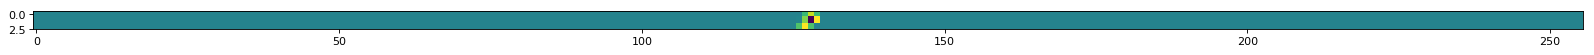

In [71]:
display_im(wd_e)

In [73]:
wd_m = encode_word("make")

In [61]:
kys = load_keys()

In [68]:
mnv,mxv = min(kys['ky'].values()),max(kys['ky'].values())
print(mnv, " ",mxv)
vl = mxv * 0.999
nv = -1 + (2.0 / (mxv - mnv)) * (vl - mnv)
print(nv)

0.0015615092128185113   0.10772124385068114
0.9979705818930662


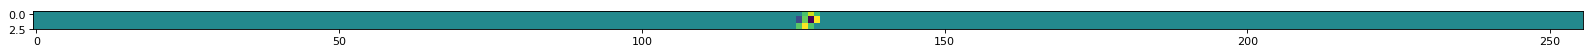

In [74]:
display_im(wd_m)

In [75]:
wd_m[1]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [60]:
wd_e[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     